In [9]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tnrange
from sklearn.svm import SVC

In [10]:
from telepyth import TelepythClient
tp = TelepythClient()
from experiment import get_dataset, mean_confidence_interval

Use token from .telepythrc.


In [11]:
from kernels import approximate_arccos0_kernel, approximate_arccos1_kernel, \
                    approximate_rbf_kernel, arccos0_kernel, arccos1_kernel
from rom import generate_rademacher_weights, generate_gort_weights
from utils import generate_random_weights, generate_householder_weights, \
                    generate_butterfly_weights, radius, butterfly_params, \
                    generate_halton_weights
from mapping import fast_batch_approx_rbf, fast_batch_approx_arccos1, \
                fast_batch_approx_arccos0
from sklearn.metrics.pairwise import rbf_kernel
from gaussquad import generate_gq_weights, explicit_map, rbf_kernel_via_explicit_map

In [12]:
import ctypes
mkl_rt = ctypes.CDLL('libmkl_rt.so')
print(mkl_rt.mkl_get_max_threads())
mkl_get_max_threads = mkl_rt.mkl_get_max_threads
def mkl_set_num_threads(cores):
    mkl_rt.mkl_set_num_threads(ctypes.byref(ctypes.c_int(cores)))

mkl_set_num_threads(16)
print(mkl_get_max_threads())

16
16


# LETTER

In [151]:
dataset_name = 'LETTER'
dataset, d = get_dataset(dataset_name, 10000)
xtrain, ytrain, xtest, ytest = dataset
n1 = xtrain.shape[0]
n2 = xtest.shape[0]
maxv = np.max(np.vstack((xtrain, xtest)))
xtrain /= maxv
xtest /= maxv

In [154]:
K_rbf = rbf_kernel(xtrain, xtrain, gamma = 1./16)
print(K_rbf[:5, :5])

[[ 1.          0.93291196  0.94622227  0.95202245  0.94412189]
 [ 0.93291196  1.          0.98374468  0.95308084  0.9373278 ]
 [ 0.94622227  0.98374468  1.          0.96560542  0.93550699]
 [ 0.95202245  0.95308084  0.96560542  1.          0.93602686]
 [ 0.94412189  0.9373278   0.93550699  0.93602686  1.        ]]


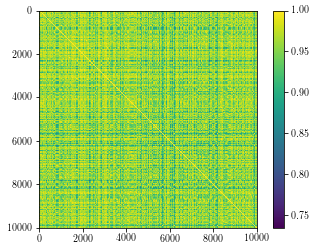

In [156]:
plt.imshow(K_rbf)
plt.colorbar()

In [157]:
K_rbf = rbf_kernel(xtrain, xtrain, gamma = 5.612627664588043)
print(K_rbf[:5, :5])

[[ 1.          0.00195718  0.00698453  0.01209132  0.00572097]
 [ 0.00195718  1.          0.22952216  0.01336004  0.00299088]
 [ 0.00698453  0.22952216  1.          0.04315006  0.00251168]
 [ 0.01209132  0.01336004  0.04315006  1.          0.00264017]
 [ 0.00572097  0.00299088  0.00251168  0.00264017  1.        ]]


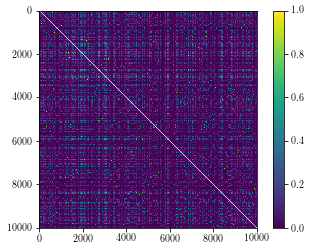

In [158]:
plt.imshow(K_rbf)
plt.colorbar()

In [159]:
K_rbf = rbf_kernel(xtrain, xtrain, gamma = 1.)
print(K_rbf[:5, :5])

[[ 1.          0.32919299  0.41294352  0.45536014  0.39851904]
 [ 0.32919299  1.          0.76934004  0.46352781  0.35502909]
 [ 0.41294352  0.76934004  1.          0.57120906  0.34415379]
 [ 0.45536014  0.46352781  0.57120906  1.          0.34722657]
 [ 0.39851904  0.35502909  0.34415379  0.34722657  1.        ]]


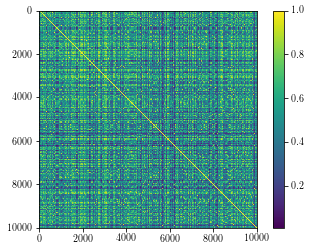

In [160]:
plt.imshow(K_rbf)
plt.colorbar()

## Classification accuracy

In [14]:
clf_rbf = SVC(gamma=5.612627664588043)
clf_rbf.fit(xtrain, ytrain)
exact_rbf = clf_rbf.score(xtest, ytest)

In [15]:
print(exact_rbf)

0.9505


In [145]:
def get_scores(dataset, approx_type, estimator, K, runs):
    xtrain, ytrain, xtest, ytest = dataset
    n = xtrain.shape[1]
    n1 = xtrain.shape[0]
    n2 = xtest.shape[0]
    
    rbf_scores = np.empty((K, runs))

    if approx_type == 'B simplex':
        stacked_train = np.asfortranarray(np.vstack([xtrain, xtrain])).T
        stacked_test = np.asfortranarray(np.vstack([xtest, xtrain])).T
        
    for k in tnrange(K):
        for j in tnrange(runs):
            shift=3
            t = 2 * (k+shift)
            L = 2 * (k+shift) * (n+1)
            r = radius(n, t)
            b_params = butterfly_params(n, t)
            if approx_type == 'B simplex':
                gs = [3.24640298525901, 3.4480681967253055,
                      5.366980000769137, 5.201047278743865, 5.549978767049045]
                g = 5.549978767049045
                #5.201047278743865
                #5.366980000769137
                #3.4480681967253055
                #3.24640298525901
                #2.6787612075263656
                K_train = fast_batch_approx_rbf(stacked_train, n1, k+shift, r, b_params, gamma=g)
                K_test = fast_batch_approx_rbf(stacked_test, n2, k+shift, r, b_params, gamma=g)
            
            elif approx_type == 'GQ':
                W, A = generate_gq_weights(n, L, 2)
                Te, Tr = explicit_map(xtest, xtrain, W, gamma=4.361971052314368)
                                      #3.700174794759857)
                                      #3.4560544174518197)
                                      #3.0440987699759585)
                                      #2.4504327709444915)#2.3773499688956248)
                K_train = rbf_kernel_via_explicit_map(Tr, Tr, A)
                K_test = rbf_kernel_via_explicit_map(Te, Tr, A)
            else:
                if approx_type == 'random':
                    M, w = generate_random_weights(k+shift, n)
                    gamma = 5.40954476756869
                    #3.3475047124416824
                    #4.074321107754087
                    #4.520383020694268
                elif approx_type == 'ROM':
                    M, w = generate_rademacher_weights(k+shift, n)
                    gamma = 2.999414245509632
                    #5.1541337967399805
                    #5.121263198730015
                    #4.093929767090474
                    #2.999414245509632
                    #2.477305595711522
                elif approx_type == 'gort':
                    M, w = generate_random_weights(k+shift, n)   
                    gamma = 4.249936540582294
                    #5.655095172992773
                    #4.594652661067792
                    #4.249936540582294
                    #3.284766795001592
                    #2.2065763505421403
                    #2.368712491007913
                elif approx_type == 'dense B':
                    M, w = generate_butterfly_weights(k+shift, n)
                    gamma = 4.577176503299288
                elif approx_type == 'halton':
                    M, w = generate_halton_weights(k+shift, n)
                    gamma = 4.577176503299288
                else:
                    raise Exception('no approx type specified')

                K_train = approximate_rbf_kernel(xtrain, xtrain, M, w, gamma=gamma)
                K_test = approximate_rbf_kernel(xtest, xtrain, M, w, gamma=gamma)
    
    
            clf_rbf_pre = estimator(kernel='precomputed')
            clf_rbf_pre.fit(K_train, ytrain)
            rbf_scores[k][j] = clf_rbf_pre.score(K_test, ytest)

    return rbf_scores

In [138]:
K = 1
runs = 10

In [48]:
%%time
%%telepyth
gq_rbf_scores5 = get_scores(dataset, 'GQ', SVC, K, runs)

A Jupyter Widget

A Jupyter Widget


CPU times: user 1min 25s, sys: 7.66 s, total: 1min 33s
Wall time: 1min 7s


In [132]:
%%time
%%telepyth
B_rbf_scores5 = get_scores(dataset, 'B simplex', SVC, K, runs)

A Jupyter Widget

A Jupyter Widget


CPU times: user 1min 47s, sys: 11.9 s, total: 1min 59s
Wall time: 1min 33s


In [70]:
%%time
%%telepyth
g_rbf_scores4 = get_scores(dataset, 'random', SVC, K, runs)

A Jupyter Widget

A Jupyter Widget


CPU times: user 1min 26s, sys: 11.2 s, total: 1min 37s
Wall time: 1min 11s


In [118]:
%%time
%%telepyth
rom_rbf_scores2 = get_scores(dataset, 'ROM', SVC, K, runs)

A Jupyter Widget

A Jupyter Widget


CPU times: user 1min 9s, sys: 9.51 s, total: 1min 18s
Wall time: 1min 1s


In [146]:
%%time
%%telepyth
gort_rbf_scores3 = get_scores(dataset, 'gort', SVC, K, runs)

A Jupyter Widget

A Jupyter Widget


CPU times: user 1min 19s, sys: 11.6 s, total: 1min 31s
Wall time: 1min 9s


In [23]:
def plot_(scores_, labels, kernel_type, dataset_name, exact):
    fig = plt.figure()
    ax = fig.add_subplot('111')
    
    for i,scores in enumerate(scores_):
        x = 2 * (np.arange(0, K, 1) + 1) * (d + 1)
        ci = np.empty((scores.shape[0], 2))
        mean = np.zeros(scores.shape[0])
        for j in range(scores.shape[0]):
            mean[j], ci[j,0], ci[j,1] = mean_confidence_interval(scores[j,:])
        ax.plot(x, mean, '.-', label=labels[i])
        ax.fill_between(x, np.maximum(0, ci[:, 0]), ci[:, 1], alpha = 0.3)
        
    ax.axhline(exact, linestyle='--', label='exact', color='black')
           
    ax.set_xlabel(r'nfeatures', fontsize=16)
    ax.set_ylabel(r'accuracy', fontsize=16)
    title = f'SVC accuracy using {kernel_type} kernel approximation, {dataset_name}'
    fig.suptitle(title, fontsize=16)
    ax.legend(loc='best', framealpha=0.1)
    plt.tight_layout(pad=3)
    plt.savefig('figure_data/GQaccuracy%s%s.pdf' % (dataset_name, kernel_type), dpi=1200, format='pdf')
    

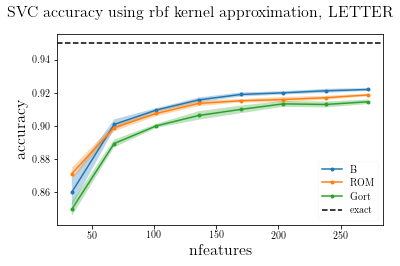

In [30]:
types = ['B', 'ROM', 'Gort']
rbf_scores = [B_rbf_scores, rom_rbf_scores, gort_rbf_scores]
plot_(rbf_scores, types, 'rbf', dataset_name, exact_rbf)

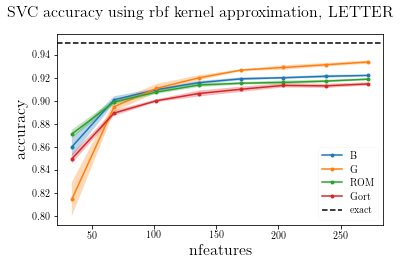

In [24]:
types = ['B', 'G', 'ROM', 'Gort']
rbf_scores = [B_rbf_scores, g_rbf_scores, rom_rbf_scores, gort_rbf_scores]
plot_(rbf_scores, types, 'rbf', dataset_name, exact_rbf)

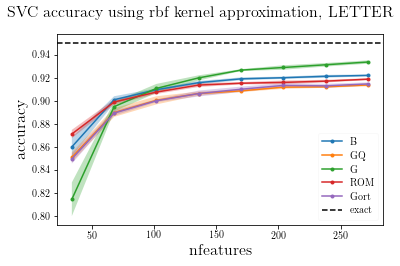

In [28]:
types = ['B', 'GQ', 'G', 'ROM', 'Gort']
rbf_scores = [B_rbf_scores, gq_rbf_scores, g_rbf_scores, rom_rbf_scores, gort_rbf_scores]
plot_(rbf_scores, types, 'rbf', dataset_name, exact_rbf)

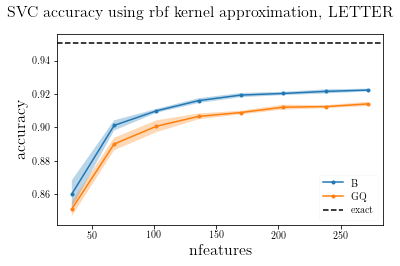

In [29]:
types = ['B', 'GQ']#, 'G', 'ROM', 'Gort']
rbf_scores = [B_rbf_scores, gq_rbf_scores]#, g_rbf_scores, rom_rbf_scores, gort_rbf_scores]
plot_(rbf_scores, types, 'rbf', dataset_name, exact_rbf)

In [50]:
gq_rbf_scores.shape

(8, 10)

In [51]:
gq_rbf_scoresc = gq_rbf_scores[:5,:]

In [52]:
gq_rbf_scoresc[1,:] = gq_rbf_scores2
gq_rbf_scoresc[2,:] = gq_rbf_scores3
gq_rbf_scoresc[3,:] = gq_rbf_scores4
gq_rbf_scoresc[4,:] = gq_rbf_scores5

In [57]:
gq_rbf_scoresc.shape, B_rbf_scores[:5,:].shape

((5, 10), (5, 10))

In [72]:
g_rbf_scoresc = g_rbf_scores[:5,:]
g_rbf_scoresc[1,:] = g_rbf_scores2
g_rbf_scoresc[2,:] = g_rbf_scores3
g_rbf_scoresc[3,:] = g_rbf_scores4
# g_rbf_scoresc[4,:] = g_rbf_scores5

In [133]:
B_rbf_scoresc = B_rbf_scores[:5,:]
B_rbf_scoresc[1,:] = B_rbf_scores2
B_rbf_scoresc[2,:] = B_rbf_scores3
B_rbf_scoresc[3,:] = B_rbf_scores4
B_rbf_scoresc[4,:] = B_rbf_scores5

In [119]:
rom_rbf_scoresc = rom_rbf_scores[:5,:]
rom_rbf_scoresc[1,:] = rom_rbf_scores2
rom_rbf_scoresc[2,:] = rom_rbf_scores3
rom_rbf_scoresc[3,:] = rom_rbf_scores4
rom_rbf_scoresc[4,:] = rom_rbf_scores5

In [122]:
rom_rbf_scores[:5,:]

array([[ 0.8807,  0.8736,  0.8693,  0.8787,  0.8662,  0.8674,  0.8654,
         0.8716,  0.8706,  0.87  ],
       [ 0.9032,  0.9037,  0.9034,  0.9024,  0.9043,  0.8994,  0.905 ,
         0.8964,  0.905 ,  0.9052],
       [ 0.9242,  0.9194,  0.9157,  0.9226,  0.9149,  0.9155,  0.9166,
         0.9122,  0.9138,  0.9133],
       [ 0.9305,  0.924 ,  0.924 ,  0.9257,  0.9282,  0.9206,  0.9203,
         0.9261,  0.9142,  0.9262],
       [ 0.9333,  0.9279,  0.9321,  0.9315,  0.933 ,  0.9299,  0.9306,
         0.9281,  0.9299,  0.9322]])

In [120]:
rom_rbf_scoresc

array([[ 0.8807,  0.8736,  0.8693,  0.8787,  0.8662,  0.8674,  0.8654,
         0.8716,  0.8706,  0.87  ],
       [ 0.9032,  0.9037,  0.9034,  0.9024,  0.9043,  0.8994,  0.905 ,
         0.8964,  0.905 ,  0.9052],
       [ 0.9242,  0.9194,  0.9157,  0.9226,  0.9149,  0.9155,  0.9166,
         0.9122,  0.9138,  0.9133],
       [ 0.9305,  0.924 ,  0.924 ,  0.9257,  0.9282,  0.9206,  0.9203,
         0.9261,  0.9142,  0.9262],
       [ 0.9333,  0.9279,  0.9321,  0.9315,  0.933 ,  0.9299,  0.9306,
         0.9281,  0.9299,  0.9322]])

In [109]:
rom_rbf_scores3

array([[ 0.9242,  0.9194,  0.9157,  0.9226,  0.9149,  0.9155,  0.9166,
         0.9122,  0.9138,  0.9133]])

In [110]:
rom_rbf_scores[:5,:]

array([[ 0.8807,  0.8736,  0.8693,  0.8787,  0.8662,  0.8674,  0.8654,
         0.8716,  0.8706,  0.87  ],
       [ 0.9011,  0.8928,  0.9008,  0.9001,  0.8958,  0.9016,  0.9004,
         0.9031,  0.8994,  0.8965],
       [ 0.908 ,  0.9109,  0.9039,  0.9083,  0.9041,  0.9099,  0.9087,
         0.9086,  0.9088,  0.9069],
       [ 0.9136,  0.917 ,  0.9117,  0.9171,  0.9141,  0.9143,  0.916 ,
         0.9122,  0.9133,  0.9098],
       [ 0.9143,  0.9171,  0.9176,  0.9136,  0.9153,  0.9141,  0.9151,
         0.9172,  0.9162,  0.9143]])

In [147]:
gort_rbf_scoresc = gort_rbf_scores[:5,:]
gort_rbf_scoresc[1,:] = gort_rbf_scores2
gort_rbf_scoresc[2,:] = gort_rbf_scores3
gort_rbf_scoresc[3,:] = gort_rbf_scores4
gort_rbf_scoresc[4,:] = gort_rbf_scores5

In [148]:
K = 5

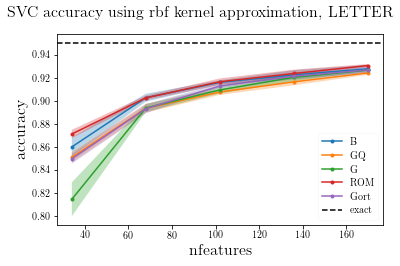

In [149]:
types = ['B', 'GQ', 'G', 'ROM', 'Gort']
rbf_scores = [B_rbf_scores[:5,:], gq_rbf_scoresc, g_rbf_scores[:5,:], rom_rbf_scoresc, gort_rbf_scoresc]
plot_(rbf_scores, types, 'rbf', dataset_name, exact_rbf)

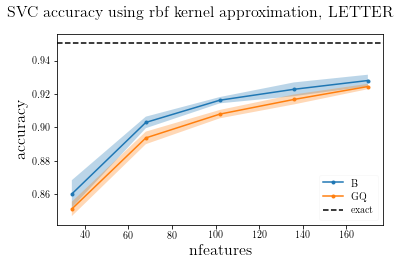

In [150]:
types = ['B', 'GQ']#, 'G', 'ROM', 'Gort']
rbf_scores = [B_rbf_scores[:5,:], gq_rbf_scoresc]#, g_rbf_scores[:5,:], rom_rbf_scoresc, gort_rbf_scoresc]
plot_(rbf_scores, types, 'rbf', dataset_name, exact_rbf)

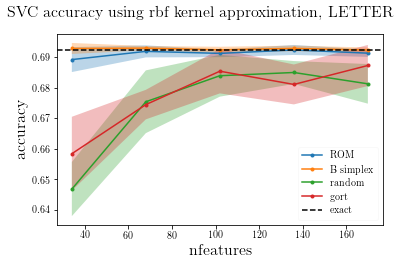

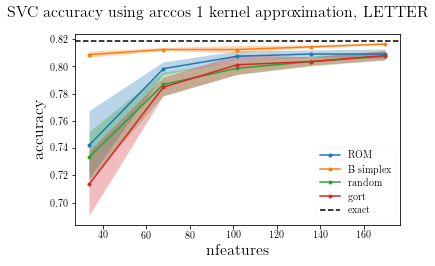

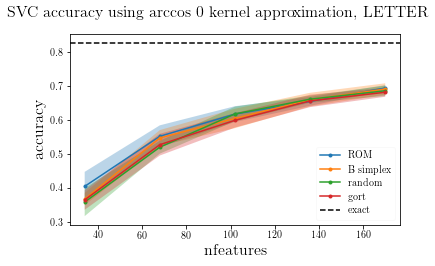

In [26]:
# types = ['ROM', 'B simplex', 'random', 'gort']
types = ['B', 'GQ']
rbf_scores = [rom_rbf_scores, B_rbf_scores, g_rbf_scores, gort_rbf_scores]
arccos_scores = [rom_arccos_scores, B_arccos_scores, g_arccos_scores, gort_arccos_scores]
arccos0_scores = [rom_arccos0_scores, B_arccos0_scores, g_arccos0_scores, gort_arccos0_scores]
plot_(rbf_scores, 
      types, 'rbf', dataset_name, exact_rbf)
plot_(arccos_scores, 
      types, 'arccos 1', dataset_name, exact_arccos1)
plot_(arccos0_scores, 
      types, 'arccos 0', dataset_name, exact_arccos0)

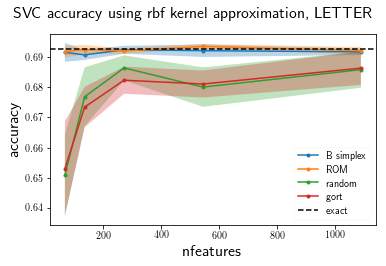

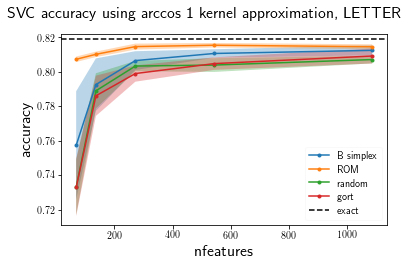

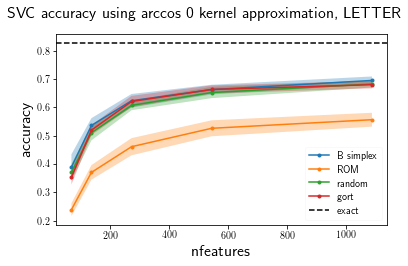

In [171]:
# types = ['B simplex', 'ROM', 'random', 'gort']
types = ['ROM', 'B simplex', 'random', 'gort']

rbf_scores = [rom_rbf_scores, B_rbf_scores, g_rbf_scores, gort_rbf_scores]
arccos_scores = [rom_arccos_scores, B_arccos_scores, g_arccos_scores, gort_arccos_scores]
arccos0_scores = [rom_arccos0_scores, B_arccos0_scores, g_arccos0_scores, gort_arccos0_scores]
plot_(rbf_scores, 
      types, 'rbf', dataset_name, exact_rbf)
plot_(arccos_scores, 
      types, 'arccos 1', dataset_name, exact_arccos1)
plot_(arccos0_scores, 
      types, 'arccos 0', dataset_name, exact_arccos0)

In [20]:
scores_dic = {'RBF': {t:s for t, s in zip(types, rbf_scores)},
              'Arc-cosine 0': {t:s for t, s in zip(types, arccos0_scores)},
              'Arc-cosine 1': {t:s for t, s in zip(types, arccos_scores)}}

In [21]:
np.savez(f'figure_data/acc/accuracy{dataset_name}', scores_dic)

In [22]:
exact = [exact_rbf, exact_arccos0, exact_arccos1]
np.save(f'figure_data/acc/exact{dataset_name}', np.array(exact))

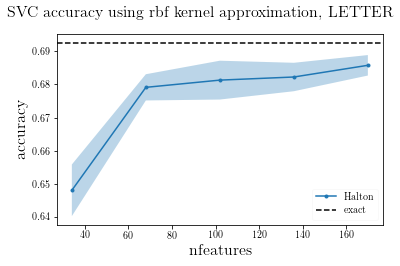

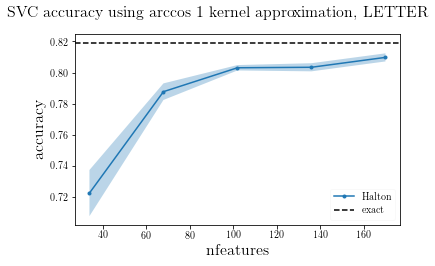

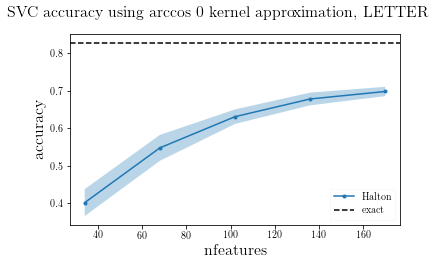

In [17]:
types = ['Halton']
rbf_scores = [halton_rbf_scores]
arccos0_scores = [halton_arccos0_scores]
arccos1_scores = [halton_arccos_scores]
plot_(rbf_scores, 
      types, 'rbf', dataset_name, exact_rbf)
plot_(arccos1_scores, 
      types, 'arccos 1', dataset_name, exact_arccos1)
plot_(arccos0_scores, 
      types, 'arccos 0', dataset_name, exact_arccos0)

scores_dic = {'RBF': {t:s for t, s in zip(types, rbf_scores)},
              'Arc-cosine 0': {t:s for t, s in zip(types, arccos0_scores)},
              'Arc-cosine 1': {t:s for t, s in zip(types, arccos1_scores)}}

np.savez(f'figure_data/acc/haltonaccuracy{dataset_name}', scores_dic)